<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1">Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2">Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3">Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-LinearRegression" data-toc-modified-id="Модель-LinearRegression-3.1">Модель <code>LinearRegression</code></a></span></li><li><span><a href="#Модель-RandomForestRegressor" data-toc-modified-id="Модель-RandomForestRegressor-3.2">Модель <code>RandomForestRegressor</code></a></span></li><li><span><a href="#Модель-CatBoostRegressor" data-toc-modified-id="Модель-CatBoostRegressor-3.3">Модель <code>CatBoostRegressor</code></a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4">Тестирование</a></span></li><li><span><a href="#Итоговый-вывод" data-toc-modified-id="Итоговый-вывод-5">Итоговый вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6">Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Необходимо:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**План работы над задачей:**

1) **Подготовка** — изучим данные на предмет возникновения в них аномалий, пропусков и ошибок. В случае нахождения — обработаем их. 

2) **Анализ** — построим график временного ряда и проведём его декомпозицию с целью выявить тренд и сезонность.

3) **Обучение моделей** — обучим модели LinearRegression, RandomForestRegressor и CatBoostRegressor и определим их лучшие гиперпараметры и показатели метрики RMSE.

4) На этапе **тестирования** определим показатель метрики RMSE лучшей модели на тестовой выборке, проанализируем предсказания модели и проверим её на адекватность путём сравнения с дамми-моделью.

5) Сделаем **итоговый вывод** об основных итогах исследования и предложим заказчику лучшую модель.

In [1]:
!pip install phik -q
!pip install scikit-learn==1.1.3 -q

import pandas as pd
import numpy as np
import os

from scipy import stats as st
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import  mean_squared_error
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, MinMaxScaler,
    OrdinalEncoder, LabelEncoder, RobustScaler
)

from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor

In [2]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rcParams, rcParamsDefault
rcParams['figure.figsize'] = 10, 6
%config InlineBackend.figure_format = 'svg'
pd.set_option('display.max_columns', None)

In [3]:
def plot_describe (t, x_l, y_l): # Заранее пропишем функцию, подписывающую название графика и осей
    plt.title(t)                 # Здесь параметр t будет отвечать за название графика  
    plt.xlabel(x_l)              # Параметр x_l — за подпись горизонтальной оси
    plt.ylabel(y_l)              # Параметр y_l — за подпись вертикальной оси
    plt.show()

TEST_SIZE = 0.1
RANDOM_STATE = 42

## Подготовка

In [4]:
pth1 = 'C:/pr/datasets/taxi.csv' # Считаем csv-файл
pth2 = '/datasets/taxi.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
elif os.path.exists(pth2):
    data = pd.read_csv(pth2, index_col=[0], parse_dates=[0])
else:
    print('Something is wrong')

Изучим общую информацию о датасете. Однако, прежде чем мы приступим к её разбору, напишем **вспомогательную функцию**. Так проводить анализ будет быстрее и удобнее:

In [5]:
def describe_data (data):
    print('Первые пять строк таблицы:')
    display(data.head())
    print('\n', 'Последние пять строк таблицы:')
    display(data.tail())
    print('\n', 'Общая информация о датасете:', '\n')
    data.info()
    print('\n', 'Описательные статистики датасета:')
    display(data.describe().round(2))
    print('\n', 'Количество пропусков в данных:')
    display(data.isna().sum())

In [6]:
describe_data(data) # Изучаем данные о датасете

Первые пять строк таблицы:


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32



 Последние пять строк таблицы:


,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53



 Общая информация о датасете: 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB

 Описательные статистики датасета:


,num_orders
count,26496.00
mean,14.07
std,9.21
min,0.00
25%,8.00
50%,13.00
75%,19.00
max,119.00



 Количество пропусков в данных:


num_orders    0
dtype: int64

Проверим данные на монотонность по индексу (это важно ввиду того, что отсутствие монотонности может свидетельствовать о проблемах с данными, таких как дублирование записей, ошибки введения данных или неточные временные метки, что впоследствии может привести к ошибкам в анализе):

In [7]:
data.index.is_monotonic

True

Данные монотонны по времени. Выполним их ресемплирование по одному часу (поскольку заказчику важно знать предсказания в рамках следующего часа):

In [8]:
data = data.resample('1H').sum()
data.isna().sum() # Проверим, не появилось ли пропусков

num_orders    0
dtype: int64

**Промежуточный вывод:**

- В данных не обнаружено пропусков.
- Данные монотонны по времени.
- Данные ресемплированы по часу (важно в рамках постановки задачи заказчиком).

## Анализ

Построим график временного ряда:

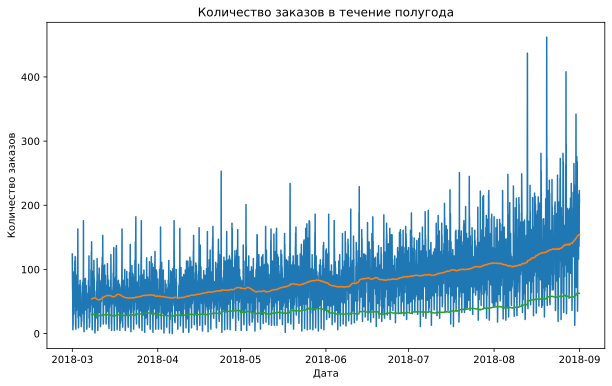

In [9]:
plt.plot(data, label='_nolegend_')
plt.plot(data['num_orders'].shift().rolling(168).mean())
plt.plot(data['num_orders'].shift().rolling(168).std())
plot_describe('Количество заказов в течение полугода', 'Дата', 'Количество заказов')

Можем заметить тренд к росту количества заказов в августе. Изучим средние значения количества заказов за первую половину рассматриваемого промежутка времени (март-май) и за вторую (июнь-август):

In [10]:
print(f'Среднее значение март-май: {round(data[: "2018-05-31"]["num_orders"].mean(), 2)}')
print(f'Среднее значение июнь-август: {round(data["2018-06-01":]["num_orders"].mean(), 2)}')

Среднее значение март-май: 65.0
Среднее значение июнь-август: 103.84


С ростом тренда меняется и среднее значение, а, следовательно, можно выдвинуть предположение о том, что ряд нестационарен. Однако, по одному только среднему значению сделать однозначный вывод об этом нельзя. Проведём тест Дики-Фуллера для получения наиболее точного результата. Однако, прежде всего для его проведения необходимо сформулировать нулевую и альтернативную гипотезы:

- Нулевая гипотеза (H0): предполагает, что временной ряд имеет единичный корень, то есть он нестационарный.
- Альтернативная гипотеза (H1): предполагает, что временной ряд не имеет единичного корня, то есть он является стационарным.

In [11]:
test = adfuller(data)

print('ADF Statistic: ', test[0])
print('p-value: ', test[1])
print('Critical Values:', test[4])
if test[0] > test[4]['5%']:
    print('есть единичные корни, ряд нестационарен')
else:
    print('единичных корней нет, ряд стационарен')

ADF Statistic:  -3.0689242890279558
p-value:  0.028940051402612906
Critical Values: {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
единичных корней нет, ряд стационарен


По итогам проведения теста можно прийти к заключению о том, что ряд всё же стационарен, однако, забегая вперёд, можно всё же судить о ложном срабатывании теста ввиду наличия у временного ряда тренда и сезонности (можно увидеть чуть ниже), что "по определению" исключает стационарность.

Теперь проведём декомпозицию временного ряда на тренд, сезонность и остатки, а также построим соответствующие графики:

In [12]:
decomposed = seasonal_decompose(data)

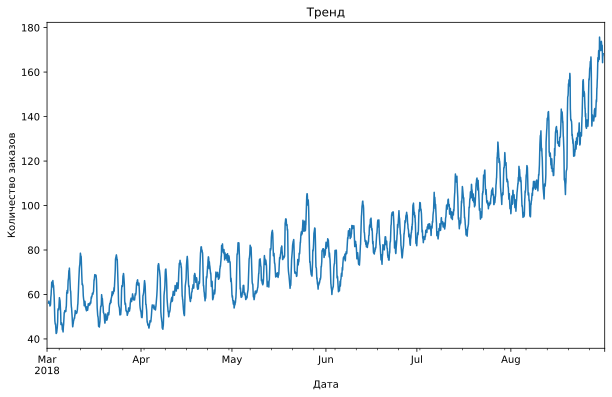

In [13]:
decomposed.trend.plot(ax = plt.gca())
plot_describe('Тренд', 'Дата', 'Количество заказов')

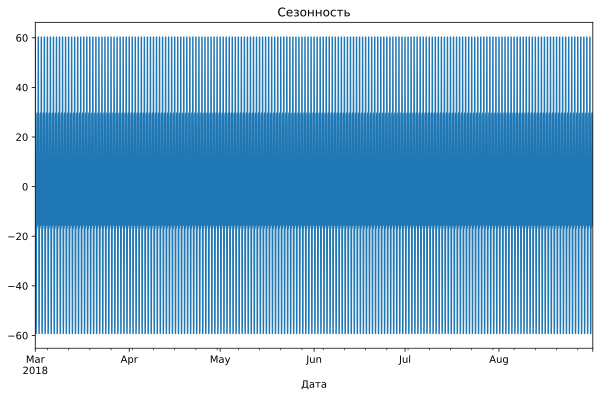

In [14]:
decomposed.seasonal.plot(ax = plt.gca())
plot_describe('Сезонность', 'Дата', '')

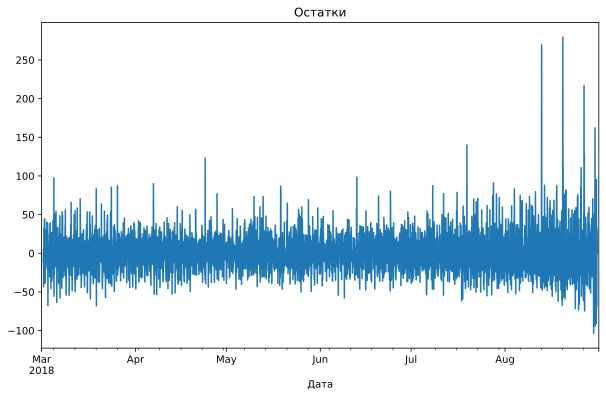

In [15]:
decomposed.resid.plot(ax = plt.gca())
plot_describe('Остатки', 'Дата', '')

Попробуем проанализировать полученные графики:
- График тренда довольно предсказуем ввиду того, что наблюдаемый на нём рост заказов такси вблизи аэропорта в летний период времени наверняка связан с летним сезоном отпусков. 
- По графику сезонности на данный момент сложно сделать какие-либо выводы ввиду его "нечитаемости" в рамках рассматриваемого периода времени. Попробуем взять период поменьше — например, неделю.

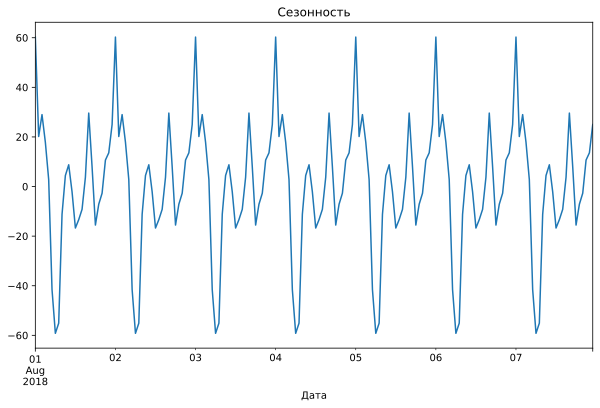

In [16]:
decomposed.seasonal['2018-08-01':'2018-08-07'].plot(ax = plt.gca())
plot_describe('Сезонность', 'Дата', '')

На этот раз разобраться в графике намного проще — сезонность представляет из себя колебания с периодом в один день. Рассмотрим, как ведёт себя график в масштабах одного дня:

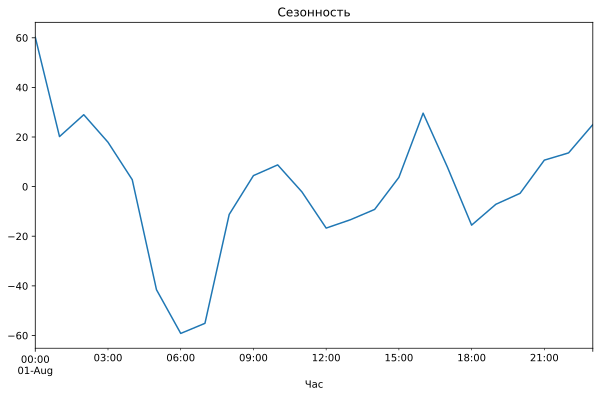

In [17]:
decomposed.seasonal['2018-08-01'].plot(ax = plt.gca())
plot_describe('Сезонность', 'Час', '')

Наибольшее количество заказов приходится на полночь и после постепенно снижается до шести утра, где достигает минимума. После этого вновь начинает расти, но "проседает" в районе 12 и 18 часов.

Также будет полезно изучить динамику количества заказов за август, на который приходится пик тренда. Для этого построим график скользящего среднего:

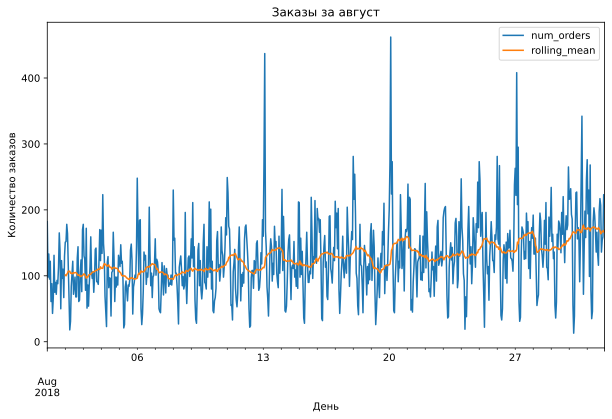

In [18]:
data_aug = data.loc['2018-08-01':].copy()
data_aug.loc[:, 'rolling_mean'] = data_aug['num_orders'].shift().rolling(24).mean()
data_aug.plot()
plot_describe('Заказы за август', 'День', 'Количество заказов')

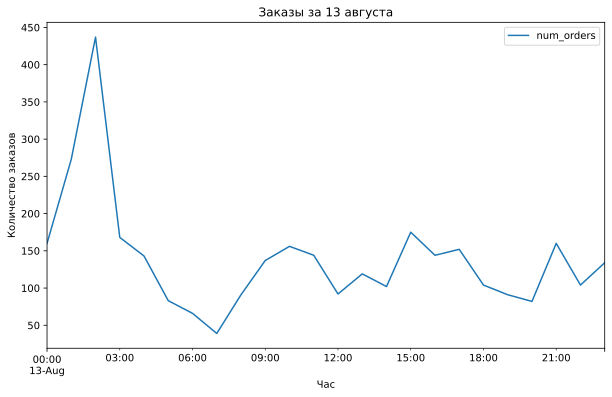

In [19]:
data_aug_13 = data.loc['2018-08-13'].copy() 
data_aug_13.plot()
plot_describe('Заказы за 13 августа', 'Час', 'Количество заказов')

**Промежуточные выводы:**

- Построен график временного ряда, по которому заметен явный тренд к росту числа заказов в августе.
- Выдвинута гипотеза о том, что ряд нестационарен в связи с тем, что среднее значение временного ряда возрастает в летний период (по сравнению с весенним). И, несмотря на ложное срабатывание теста Дики-Фуллера, эта гипотеза подтвердилась наличием у ряда тренда и сезонности.
- Проведена декомпозиция временного ряда, позволившая сделать выводы о том, что тренд действительно существенно возрастает в августе (что легко связать с окончанием летнего сезона отпусков), а также о том, что сезонность представляет из себя колебания с периодом в один день. К тому же, было выявлено, что в рамках каждого дня наибольшее количество заказов приходится на полночь и после постепенно снижается до шести утра, где достигает минимума. После этого вновь начинает расти, но "проседает" в районе 12 и 18 часов.
- Выявлены локальные пики 6, 13, 20 и 27 августа (при помощи анализа динамики количества заказов за август). В 2018 году все эти дни приходились на понедельник, а пик заказов в каждый из дней был в районе 2-3 часов ночи. Объяснить это можно тем, что большое количество людей возвращалось из отпуска, и в понедельник им нужно было уже выходить на работу.

## Обучение

Напишем функцию добавления признаков по параметрам:

In [20]:
def make_features(df, lag, roll_size):
    df_new = df.copy()
    df_new['day'] = df_new.index.day
    df_new['dayofweek'] = df_new.index.dayofweek
    
    for i in range(1, lag + 1):
        df_new['lag_{}'.format(lag)] = df_new['num_orders'].shift(lag)
        
    df_new['rolling_mean'] = df_new['num_orders'].shift().rolling(roll_size).mean()
    df_new.dropna(inplace=True)
    return df_new

In [21]:
data_features = make_features(data, 168, 168)
ohe_columns = ['day', 'dayofweek'] # Кодируем данные признаки как категориальные для корректной работы 
num_columns = ['lag_168', 'rolling_mean']

X = data_features.drop('num_orders', axis = 1)
y = data_features['num_orders']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle = False,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE
)

Обучим модели LinearRegression, RandomForestRegressor и CatBoostRegressor:

### Модель `LinearRegression`

Для корректной работы модели линейной регрессии используем пайплайн:

In [22]:
ohe_pipe = Pipeline( # Cоздаём пайплайн для подготовки признаков из списка ohe_columns
   [  
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore')
        )
       
    ]
)   

data_preprocessor = ColumnTransformer( # Cоздаём общий пайплайн для подготовки данных
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([ # Создаём итоговый пайплайн
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [23]:
ts_cv = TimeSeriesSplit(n_splits=5)

lin_params = [
    { # Словарь для модели LinearRegression()
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    }
]

lin_scores = RandomizedSearchCV(
    pipe_final,
    lin_params,
    cv=ts_cv,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

lin_scores.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['day',
                                                                                'dayofweek']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['lag_168',
                                                                                'rolling_mean'])])),
                                             ('models', LinearRegression())]),
                   n_jobs=-1,
                   param_distributions=[{'models': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='neg_root_mean_squared_error')

### Модель `RandomForestRegressor`

In [24]:
rf_model = RandomForestRegressor(random_state = RANDOM_STATE)
rf_params = {
    'n_estimators': range(10, 100),  
    'max_depth': (2, 20)
}

rf_scores = RandomizedSearchCV(
    rf_model,
    rf_params,
    cv=ts_cv,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error',
)

rf_scores.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
                   param_distributions={'max_depth': (2, 20),
                                        'n_estimators': range(10, 100)},
                   random_state=42, scoring='neg_root_mean_squared_error')

### Модель `CatBoostRegressor`

In [25]:
catboost_model = CatBoostRegressor(random_state=RANDOM_STATE)
catboost_params = {
    'iterations': range(100, 200),  
    'depth': range(2, 10)
}

catboost_scores = RandomizedSearchCV(
    catboost_model,
    catboost_params,
    cv=ts_cv,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

catboost_scores.fit(X_train, y_train)

Learning rate set to 0.183294
0:	learn: 27.2928008	total: 51.1ms	remaining: 7.37s
1:	learn: 25.4756485	total: 53.7ms	remaining: 3.84s
2:	learn: 23.9432245	total: 56.2ms	remaining: 2.66s
3:	learn: 22.7292161	total: 56.7ms	remaining: 2s
4:	learn: 21.8835705	total: 59ms	remaining: 1.65s
5:	learn: 20.9974384	total: 61.4ms	remaining: 1.42s
6:	learn: 20.3312987	total: 63.8ms	remaining: 1.26s
7:	learn: 19.6900685	total: 66ms	remaining: 1.13s
8:	learn: 19.1877596	total: 68.4ms	remaining: 1.03s
9:	learn: 18.6417517	total: 70.9ms	remaining: 957ms
10:	learn: 18.2403002	total: 73.2ms	remaining: 892ms
11:	learn: 18.0417359	total: 73.5ms	remaining: 815ms
12:	learn: 17.7593528	total: 76ms	remaining: 772ms
13:	learn: 17.5053235	total: 78.4ms	remaining: 733ms
14:	learn: 17.2297661	total: 80.9ms	remaining: 701ms
15:	learn: 17.0080180	total: 83.2ms	remaining: 671ms
16:	learn: 16.8002993	total: 85.5ms	remaining: 643ms
17:	learn: 16.5865309	total: 87.8ms	remaining: 619ms
18:	learn: 16.4562595	total: 90.1ms

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=<catboost.core.CatBoostRegressor object at 0x7f824e94db80>,
                   n_jobs=-1,
                   param_distributions={'depth': range(2, 10),
                                        'iterations': range(100, 200)},
                   scoring='neg_root_mean_squared_error')

In [26]:
def result(score):  # Пропишем функцию для вывода результатов
    df = pd.DataFrame(score.cv_results_)
    df = df.drop(df.columns[1: 6], axis=1)
    df = df.drop(df.columns[2: 7], axis=1)
    return df

In [27]:
lin_result = result(lin_scores) 
lin_result # Выводим результаты для LinearRegression

,mean_fit_time,params,mean_test_score,std_test_score,rank_test_score
0,0.013421,"{'preprocessor__num': StandardScaler(), 'model...",-25.990621,2.578836,2
1,0.011959,"{'preprocessor__num': MinMaxScaler(), 'models'...",-25.990608,2.578839,1
2,0.011580,"{'preprocessor__num': 'passthrough', 'models':...",-25.990690,2.578863,3


In [28]:
rf_result = result(rf_scores) 
rf_result # Выводим результаты для RandomForestRegressor

,mean_fit_time,params,mean_test_score,std_test_score,rank_test_score
0,0.045211,"{'n_estimators': 29, 'max_depth': 2}",-27.104044,5.198665,5
1,0.080336,"{'n_estimators': 52, 'max_depth': 2}",-27.006969,5.097809,2
2,0.304036,"{'n_estimators': 73, 'max_depth': 20}",-27.486653,3.723166,8
3,0.129340,"{'n_estimators': 88, 'max_depth': 2}",-27.013648,5.053513,3
4,0.274132,"{'n_estimators': 65, 'max_depth': 20}",-27.479281,3.733848,7
5,0.038947,"{'n_estimators': 25, 'max_depth': 2}",-27.112824,5.188446,6
6,0.050741,"{'n_estimators': 34, 'max_depth': 2}",-27.061875,5.165534,4
7,0.113605,"{'n_estimators': 78, 'max_depth': 2}",-27.001044,5.056229,1
8,0.138891,"{'n_estimators': 33, 'max_depth': 20}",-27.645717,3.554351,10
9,0.164117,"{'n_estimators': 38, 'max_depth': 20}",-27.560384,3.627822,9


In [29]:
catboost_result = result(catboost_scores) 
catboost_result # Выводим результаты для CatBoostRegressor

,mean_fit_time,params,mean_test_score,std_test_score,rank_test_score
0,1.142399,"{'iterations': 145, 'depth': 9}",-29.104684,4.829932,5
1,0.925008,"{'iterations': 107, 'depth': 8}",-29.466713,4.063625,6
2,0.814002,"{'iterations': 142, 'depth': 7}",-29.899296,4.895857,8
3,0.711088,"{'iterations': 115, 'depth': 4}",-30.784694,6.395751,10
4,1.102143,"{'iterations': 140, 'depth': 9}",-29.003278,3.794769,3
5,0.826001,"{'iterations': 110, 'depth': 7}",-29.723997,4.472839,7
6,0.762799,"{'iterations': 123, 'depth': 4}",-30.100711,6.773954,9
7,1.336214,"{'iterations': 179, 'depth': 9}",-28.869398,4.986521,1
8,0.789587,"{'iterations': 124, 'depth': 6}",-29.088765,4.635908,4
9,1.176161,"{'iterations': 163, 'depth': 9}",-28.989084,4.354123,2


In [30]:
results = pd.concat([lin_result, rf_result, catboost_result])
results.loc[results['rank_test_score'] == 1] # Выводим лучшие результаты по каждой из моделей

,mean_fit_time,params,mean_test_score,std_test_score,rank_test_score
1,0.011959,"{'preprocessor__num': MinMaxScaler(), 'models'...",-25.990608,2.578839,1
7,0.113605,"{'n_estimators': 78, 'max_depth': 2}",-27.001044,5.056229,1
7,1.336214,"{'iterations': 179, 'depth': 9}",-28.869398,4.986521,1


**Промежуточные выводы:**

Значения целевой метрики RMSE на тренировочной выборке оказались сопоставимыми у всех трёх моделей, однако лучше всего себя показала модель линейной регрессии — у неё и лучшее значение (RMSE = 25,99), и наименьшее стандартное отклонение значений (2,58). К тому же, у неё наименьшее время обучения (порядка 12 мс), что также является немаловажным плюсом.

## Тестирование

Проведём тестирование на лучшей модели:

In [31]:
lin_model = Pipeline([
    ('model', LinearRegression())
])
lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
best_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE лучшей модели на тестовой выборке: {best_rmse.round(2)}')

RMSE лучшей модели на тестовой выборке: 36.5


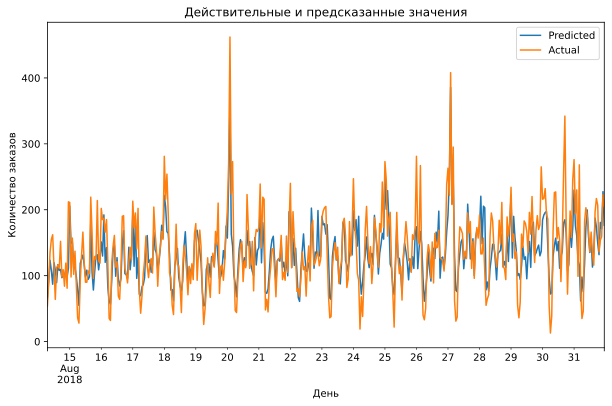

In [32]:
data_preds = pd.DataFrame(y_pred, columns=['Predicted'])
data_actual = pd.DataFrame(y_test.values, columns=['Actual'])
data_check_preds = pd.concat([data_preds, data_actual], axis=1)
data_check_preds.index = y_test.index
data_check_preds.plot()
plot_describe('Действительные и предсказанные значения', 'День', 'Количество заказов')

Для большей наглядности посмотрим на график в рамках одного из дней с наибольшим расхождением в предсказанном и реальном количествах заказов:

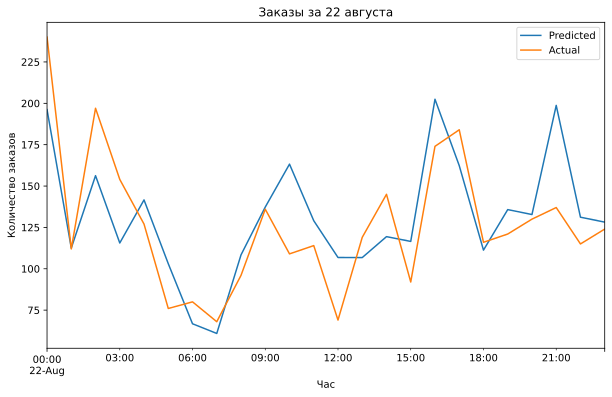

In [33]:
data_pred_aug_22 = data_check_preds.loc['2018-08-22'].copy() 
data_pred_aug_22.plot()
plot_describe('Заказы за 22 августа', 'Час', 'Количество заказов')  

Также проверим модель на адекватность при помощи `DummyRegressor`:

In [34]:
strategy = 'mean'
dummy_model = DummyClassifier(strategy=strategy)
dummy_model.fit(X_train, y_train)
dummy_model_preds = dummy_model.predict(X_test)
rmse = mean_squared_error(y_test, dummy_model_preds, squared=False)
print(f"Dummy Regression Error: {rmse.round(2)}")

Dummy Regression Error: 84.45


**Промежуточные выводы:**

- В качестве финальной модели для тестирования была выбрана модель линейной регрессии.
- Достигнутый показатель метрики RMSE равен 36.5, что меньше заявленного заказчиком порога в 48.
- Судя по графикам, модель предсказывает количество заказов довольно точно даже в худших из своих результатов (визуально на графике это 22 августа). В большинстве случаев ею переоцениваются пики в течение дня и недооцениваются точки максимума и минимума (в 00:00 и 06:00 соответственно).
- Также модель была проверена на адекватность при помощи дамми-модели, показавшей значение метрики RMSE равным 84.45, что более чем в два раза превышает показатель нашей модели, а также значительно выходит за границы обозначенного заказчиком порога в 48, что свидетельствует об адекватности выбранной модели. 

## Итоговый вывод

В качестве финальной модели для тестирования была выбрана модель линейной регрессии. Достигнутый показатель метрики RMSE на тестовых данных равен 36.5, что удовлетворяет заявленному заказчиком порогу в 48.
Судя по графикам, модель предсказывает количество заказов довольно точно даже в худших из своих результатов (визуально на графике это 22 августа). В большинстве случаев ею переоцениваются пики в течение дня и недооцениваются точки максимума и минимума (в 00:00 и 06:00 соответственно).

На этапе **подготовки** в данных не было обнаружено пропусков и мы ресемплировали их по часу.

В рамках **анализа** были достигнуты следующие результаты:
- Построен график временного ряда, по которому заметен явный тренд к росту числа заказов в августе.
- Выдвинута гипотеза о том, что ряд нестационарен в связи с тем, что среднее значение временного ряда возрастает в летний период (по сравнению с весенним). И, несмотря на ложное срабатывание теста Дики-Фуллера, эта гипотеза подтвердилась наличием у ряда тренда и сезонности.
- Проведена декомпозиция временного ряда, позволившая сделать выводы о том, что тренд действительно существенно возрастает в августе (что легко связать с окончанием летнего сезона отпусков), а также о том, что сезонность представляет из себя колебания с периодом в один день. К тому же, было выявлено, что в рамках каждого дня наибольшее количество заказов приходится на полночь и после постепенно снижается до шести утра, где достигает минимума. После этого вновь начинает расти, но "проседает" в районе 12 и 18 часов.
- Выявлены локальные пики 6, 13, 20 и 27 августа (при помощи анализа динамики количества заказов за август). В 2018 году все эти дни приходились на понедельник, а пик заказов в каждый из дней был в районе 2-3 часов ночи. Объяснить это можно тем, что большое количество людей возвращалось из отпуска, и в понедельник им нужно было уже выходить на работу.

**Обучение моделей** и перебор их гиперпараметров позволили выявить лучшую модель — ей оказалась модель линейной регрессии, показавшая на тренировочной выборке значение метрики RMSE = 25.99 при наименьшем времени обучения 12 мс.

Также модель была проверена на адекватность при помощи дамми-модели, показавшей значение метрики RMSE равным 84.45, что более чем в два раза превышает показатель нашей модели, а также значительно выходит за границы обозначенного заказчиком порога в 48, что свидетельствует об адекватности выбранной модели. 